<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

# Assignment 1 is done by:

John
<br>
Ken Ho 
<br>
Hisham 

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.04110717 -0.02655157 -0.02932773  0.04078307]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.04057614 -0.22124097 -0.02851207  0.32407045]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

### Task 1: Deep Q Network RL Agent ###

(referenced from https://github.com/ChaithanyaVamshi/CartPole-DQN-Reinforcementlearning/blob/main/CartPole_DQN.ipynb)


---
Reference for linear annealing policy with epsilon greedy policy can be found at: https://github.com/keras-rl/keras-rl/blob/master/rl/policy.py

---
Importing required libraries for agent


In [ ]:
!pip install keras-rl2 

import gym
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Input, Flatten, Dense

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip list #list of dependencies used, and their corresponding versions

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.1
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
catalogue                     2.0.8
certifi                       2022.12.7



In this case, Greedy Policy w/ epsilon is used. As covered in Monte Carlo slides, this policy starts by favouring exploration (random choice) with a large epsilon value, then increasingly favours a greedy policy by decreasing epsilon, as Q-values are refined.

We increased nb_steps_warmup for improved performance. Warmup steps are recorded as an "experience replay" for training the agent off-policy. 

In [ ]:
import rl
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

# Define the maximum capacity of the experience replay buffer to be 100,000 transitions
memory = SequentialMemory(limit=100000, window_length=1)

# Setup the policy to use for action selection
inner_policy = EpsGreedyQPolicy() # policy used 
policy = LinearAnnealedPolicy(inner_policy=inner_policy, 
                              attr='eps',       # epsilon in the inner policy to change  
                              value_max=1.0,    # maximum value of attribute that is varying
                              value_min=0.1,    # minimum value of attribute that is varying
                              value_test=0.01,  # test if the value selected is < 0.01
                              nb_steps=10000)   # 10000 steps between value_max and value_min

# Define the neural network model for Deep Q Learning (DQN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense

model = Sequential([
    Input(shape=(1, env.observation_space.shape[0])),
    Flatten(),
    Dense(24, activation='relu'),
    Dense(24, activation='relu'),
    Dense(env.action_space.n, activation='linear')
])

# Print the neural network architecture summary
print(model.summary())

# Define the DQN agent
agent = DQNAgent(model=model,
                 nb_actions=env.action_space.n,
                 memory=memory,
                 nb_steps_warmup=30,
                 target_model_update=1e-2,
                 policy=policy)

# Compile the agent with the legacy Adam optimizer and metrics to track
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
metrics = ['mae', 'accuracy']
agent.compile(optimizer=optimizer, metrics=metrics)

# Train the agent with 100,000 training steps
history = agent.fit(env, nb_steps=100000, visualize=False, verbose=2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None
Training for 100000 steps ...
    11/100000: episode: 1, duration: 0.129s, episode steps:  11, steps per second:  85, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean 

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` 

    34/100000: episode: 2, duration: 0.690s, episode steps:  23, steps per second:  33, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.478 [0.000, 1.000],  loss: 0.632392, mae: 0.639947, accuracy: 0.489583, mean_q: 0.053453, mean_eps: 0.997120
    46/100000: episode: 3, duration: 0.106s, episode steps:  12, steps per second: 113, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.577425, mae: 0.604982, accuracy: 0.489583, mean_q: 0.119692, mean_eps: 0.996445
    75/100000: episode: 4, duration: 0.276s, episode steps:  29, steps per second: 105, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.621 [0.000, 1.000],  loss: 0.395060, mae: 0.553515, accuracy: 0.529095, mean_q: 0.330072, mean_eps: 0.994600
    90/100000: episode: 5, duration: 0.132s, episode steps:  15, steps per second: 113, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1

The code below shows the agent's decision for a given observation.

In [ ]:
observation = env.reset()
action = agent.forward(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.04304064 -0.00265329 -0.00938949 -0.0178334 ]
Chosen action: 1


And a full episode, the accumulated reward.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(agent.forward(observation))
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 500.0


## Task 2: Demonstrate the effectiveness of the RL agent

Here we run the agent again for 100 times, and append the reward for each round to a list.

In [ ]:
raw_episode_results = []
no_episodes = 1
while no_episodes <=100:
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done:
    observation, reward, done, info = env.step(agent.forward(observation))
    cumulative_reward += reward

  raw_episode_results.append(cumulative_reward)
  print(f"Cumulative reward for round {no_episodes}:", cumulative_reward)
  no_episodes+=1



Cumulative reward for round 1: 500.0
Cumulative reward for round 2: 500.0
Cumulative reward for round 3: 500.0
Cumulative reward for round 4: 500.0
Cumulative reward for round 5: 500.0
Cumulative reward for round 6: 500.0
Cumulative reward for round 7: 500.0
Cumulative reward for round 8: 500.0
Cumulative reward for round 9: 500.0
Cumulative reward for round 10: 500.0
Cumulative reward for round 11: 500.0
Cumulative reward for round 12: 500.0
Cumulative reward for round 13: 500.0
Cumulative reward for round 14: 500.0
Cumulative reward for round 15: 500.0
Cumulative reward for round 16: 500.0
Cumulative reward for round 17: 500.0
Cumulative reward for round 18: 500.0
Cumulative reward for round 19: 500.0
Cumulative reward for round 20: 500.0
Cumulative reward for round 21: 500.0
Cumulative reward for round 22: 500.0
Cumulative reward for round 23: 500.0
Cumulative reward for round 24: 500.0
Cumulative reward for round 25: 500.0
Cumulative reward for round 26: 500.0
Cumulative reward for

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


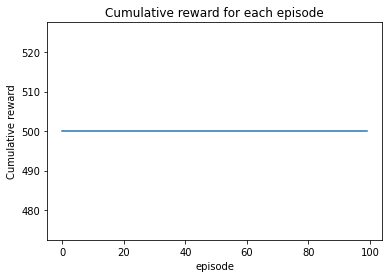

In [ ]:
episode_results = np.array(raw_episode_results)
print(raw_episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

The average reward for the DQN agent is >195.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = agent.forward(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;
    if reward==500: # break condition added to prevent the video from not working if score==500
      break;    
env.close()
show_video()